# Introduction
- nb48の編集
- type別で学習する
- ref:
    > https://www.kaggle.com/todnewman/keras-neural-net-for-champs

# Import everything I need :)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import lightgbm as lgb
from fastprogress import progress_bar

# Preparation

In [2]:
nb = 49
isSmallSet = False
length = 20000
is_cuda = torch.cuda.is_available()
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(3))

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

True


device(type='cuda', index=1)

In [3]:
pd.set_option('display.max_columns', 250)

In [4]:
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [5]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/nb47_fc_train.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/nb33_train_dist-interaction.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/nb33_test_dist-interaction.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv',
 '../input/champs-scalar-coupling/nb47_fc_test.

In [6]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)
type_train = train['type']

In [7]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[:length]
else:
    test = pd.read_csv(path)
type_test = test['type']

In [8]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [9]:
# fc_train
path = file_path + 'nb47_fc_train.csv'
# path = file_path + 'nb29_fc_train_feature.csv'
if isSmallSet:
    fc_train = pd.read_csv(path)[:length]
else:
    fc_train = pd.read_csv(path)

In [10]:
# fc_test
path = file_path + 'nb47_fc_test.csv'
# path = file_path + 'nb29_fc_test_feature.csv'
if isSmallSet:
    fc_test = pd.read_csv(path)[:length]
else:
    fc_test = pd.read_csv(path)

In [11]:
# train dist-interact
path = file_path + 'nb33_train_dist-interaction.csv'
if isSmallSet:
    dist_interact_train = pd.read_csv(path)[:length]
else:
    dist_interact_train = pd.read_csv(path)

In [12]:
# test dist-interact
path = file_path + 'nb33_test_dist-interaction.csv'
if isSmallSet:
    dist_interact_test = pd.read_csv(path)[:length]
else:
    dist_interact_test = pd.read_csv(path)

In [13]:
# ob charge train
path = file_path + 'train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv'
if isSmallSet:
    ob_charge_train = pd.read_csv(path)[:length].drop(['Unnamed: 0', 'error'], axis=1)
else:
    ob_charge_train = pd.read_csv(path).drop(['Unnamed: 0', 'error'], axis=1)

In [14]:
# ob charge test
path = file_path + 'test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv'
if isSmallSet:
    ob_charge_test = pd.read_csv(path)[:length].drop(['Unnamed: 0', 'error'], axis=1)
else:
    ob_charge_test = pd.read_csv(path).drop(['Unnamed: 0', 'error'], axis=1)

In [15]:
# mulliken charges.csv
path = file_path + 'mulliken_charges.csv'
charge = pd.read_csv(path)

In [16]:
# tensor
path = file_path + 'magnetic_shielding_tensors.csv'
tensor = pd.read_csv(path)

In [17]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


---
## myFunc
**metrics**

In [18]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

---
**momory**

In [19]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Feature Engineering

Build Distance Dataset

In [20]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_name'].isin(base['molecule_name'])]
    return base, structures

# a,b = build_type_dataframes(train, structures, '1JHN')

In [21]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_name', f'atom_index_{index}'],
                  right_on=['molecule_name', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [22]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_name', 'atom_index_0', 'atom_index_1'])
    return df

In [23]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_name'],
                  right_on=['molecule_name'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [24]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [25]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [26]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_name'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_name', right_index=True)

In [27]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_name', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_name', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_name', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
#     # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
#     atoms['molecule_name'] = atoms['molecule_name'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [28]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = ['id', 'molecule_name', 'atom_index_1', 'atom_index_0']
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [29]:
atoms = structures['atom'].values
types_train = train['type'].values
types_test = test['type'].values
structures['atom'] = structures['atom'].replace(ATOMIC_NUMBERS).astype('int8')
fulls_train = []
fulls_test  = []
for type_ in progress_bar(train['type'].unique()):
    full_train = build_couple_dataframe(train, structures, type_, n_atoms=10)
    full_test  = build_couple_dataframe(test, structures, type_, n_atoms=10)
    full_train = take_n_atoms(full_train, 10)
    full_test  = take_n_atoms(full_test, 10)
    fulls_train.append(full_train)
    fulls_test.append(full_test)
    
structures['atom'] = atoms
train = pd.concat(fulls_train).sort_values(by=['id']) #, axis=0)
test  = pd.concat(fulls_test).sort_values(by=['id']) #, axis=0)
train['type'] = types_train
test['type'] = types_test
train = train.fillna(0)
test  = test.fillna(0)

In [30]:
fulls_train[0].columns

Index(['id', 'molecule_name', 'atom_index_1', 'atom_index_0', 'atom_2',
       'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',
       'scalar_coupling_constant'],
      dtype='object')

<br>
<br>
dist-interact

In [31]:
train['dist_interact'] = dist_interact_train.values
test['dist_interact'] = dist_interact_test.values

<br>
<br>
basic

In [32]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)
    return df


# structure and ob_charges
ob_charge = pd.concat([ob_charge_train, ob_charge_test])
merge = pd.merge(ob_charge, structures, how='left',
                  left_on  = ['molecule_name', 'atom_index'],
                  right_on = ['molecule_name', 'atom_index'])
for atom_idx in [0,1]:
    train = map_atom_info(train, merge, atom_idx)
    train = map_atom_info(train, charge, atom_idx)
    train = map_atom_info(train, tensor, atom_idx)
    test  = map_atom_info(test,  merge, atom_idx)
    
    train = train.rename(columns={
                                        'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'eem': f'eem_{atom_idx}',
                                     'mmff94': f'mmff94_{atom_idx}',
                                  'gasteiger': f'gasteiger_{atom_idx}', 
                                        'qeq': f'qeq_{atom_idx}',
                                      'qtpie': f'qtpie_{atom_idx}', 
                                  'eem2015ha': f'eem2015ha_{atom_idx}', 
                                  'eem2015hm': f'eem2015hm_{atom_idx}', 
                                  'eem2015hn': f'eem2015hn_{atom_idx}', 
                                  'eem2015ba': f'eem2015ba_{atom_idx}', 
                                  'eem2015bm': f'eem2015bm_{atom_idx}', 
                                  'eem2015bn': f'eem2015bn_{atom_idx}',
                            'mulliken_charge': f'charge_{atom_idx}',
                                         'XX': f'XX_{atom_idx}',
                                         'YX': f'YX_{atom_idx}',
                                         'ZX': f'ZX_{atom_idx}',
                                         'XY': f'XY_{atom_idx}',
                                         'YY': f'YY_{atom_idx}',
                                         'ZY': f'ZY_{atom_idx}',
                                         'XZ': f'XZ_{atom_idx}',
                                         'YZ': f'YZ_{atom_idx}',
                                         'ZZ': f'ZZ_{atom_idx}',})
    test = test.rename(columns={
                                        'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'eem': f'eem_{atom_idx}',
                                     'mmff94': f'mmff94_{atom_idx}',
                                  'gasteiger': f'gasteiger_{atom_idx}', 
                                        'qeq': f'qeq_{atom_idx}', 
                                      'qtpie': f'qtpie_{atom_idx}', 
                                  'eem2015ha': f'eem2015ha_{atom_idx}', 
                                  'eem2015hm': f'eem2015hm_{atom_idx}', 
                                  'eem2015hn': f'eem2015hn_{atom_idx}', 
                                  'eem2015ba': f'eem2015ba_{atom_idx}', 
                                  'eem2015bm': f'eem2015bm_{atom_idx}', 
                                  'eem2015bn': f'eem2015bn_{atom_idx}'})
#     test  =  test.rename(columns={'atom': f'atom_{atom_idx}',
#                                         'x': f'x_{atom_idx}',
#                                         'y': f'y_{atom_idx}',
#                                         'z': f'z_{atom_idx}'})

# ob_charges
# train = map_atom_info(train, ob_charge_train, 0)
# test  = map_atom_info(test,  ob_charge_test,  0)
# train = map_atom_info(train, ob_charge_train, 1)
# test  = map_atom_info(test,  ob_charge_test,  1)

<br>
<br>
distances

In [33]:
def distances(df):
    df_p_0 = df[['x_0', 'y_0', 'z_0']].values
    df_p_1 = df[['x_1', 'y_1', 'z_1']].values
    
    df['dist'] = np.linalg.norm(df_p_0 - df_p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    
    return df

# train = distances(train)
# test  = distances(test)

<br>
<br>
統計量

In [34]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
    # fc
    df[f'molecule_type_fc_max'] = df.groupby(['molecule_name', 'type'])['fc'].transform('max')
    df[f'molecule_type_fc_min'] = df.groupby(['molecule_name', 'type'])['fc'].transform('min')
    df[f'molecule_type_fc_std'] = df.groupby(['molecule_name', 'type'])['fc'].transform('std')
    df[f'molecule_type_fc_std_diff'] = df[f'molecule_type_fc_std'] - df['fc']
    df[f'molecule_atom_index_0_fc_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['fc'].transform('mean')
    df[f'molecule_atom_index_0_fc_mean_diff'] = df[f'molecule_atom_index_0_fc_mean'] - df['fc']
    df[f'molecule_atom_index_0_fc_mean_div'] = df[f'molecule_atom_index_0_fc_mean'] / df['dist']
    df[f'molecule_atom_index_0_fc_max'] = df.groupby(['molecule_name', 'atom_index_0'])['fc'].transform('max')
    df[f'molecule_atom_index_0_fc_max_diff'] = df[f'molecule_atom_index_0_fc_max'] - df['fc']
    df[f'molecule_atom_index_0_fc_max_div'] = df[f'molecule_atom_index_0_fc_max'] / df['fc']
    df[f'molecule_atom_index_0_fc_min'] = df.groupby(['molecule_name', 'atom_index_0'])['fc'].transform('min')
    df[f'molecule_atom_index_0_fc_min_diff'] = df[f'molecule_atom_index_0_fc_min'] - df['fc']
    df[f'molecule_atom_index_0_fc_min_div'] = df[f'molecule_atom_index_0_fc_min'] / df['fc']
    df[f'molecule_atom_index_0_fc_std'] = df.groupby(['molecule_name', 'atom_index_0'])['fc'].transform('std')
    df[f'molecule_atom_index_0_fc_std_diff'] = df[f'molecule_atom_index_0_fc_std'] - df['fc']
    df[f'molecule_atom_index_0_fc_std_div'] = df[f'molecule_atom_index_0_fc_std'] / df['fc']
    df[f'molecule_atom_index_1_fc_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['fc'].transform('mean')
    df[f'molecule_atom_index_1_fc_mean_diff'] = df[f'molecule_atom_index_1_fc_mean'] - df['fc']
    df[f'molecule_atom_index_1_fc_mean_div'] = df[f'molecule_atom_index_1_fc_mean'] / df['fc']
    df[f'molecule_atom_index_1_fc_max'] = df.groupby(['molecule_name', 'atom_index_1'])['fc'].transform('max')
    df[f'molecule_atom_index_1_fc_max_diff'] = df[f'molecule_atom_index_1_fc_max'] - df['fc']
    df[f'molecule_atom_index_1_fc_max_div'] = df[f'molecule_atom_index_1_fc_max'] / df['fc']
    df[f'molecule_atom_index_1_fc_min'] = df.groupby(['molecule_name', 'atom_index_1'])['fc'].transform('min')
    df[f'molecule_atom_index_1_fc_min_diff'] = df[f'molecule_atom_index_1_fc_min'] - df['fc']
    df[f'molecule_atom_index_1_fc_min_div'] = df[f'molecule_atom_index_1_fc_min'] / df['fc']
    df[f'molecule_atom_index_1_fc_std'] = df.groupby(['molecule_name', 'atom_index_1'])['fc'].transform('std')
    df[f'molecule_atom_index_1_fc_std_diff'] = df[f'molecule_atom_index_1_fc_std'] - df['fc']
    df[f'molecule_atom_index_1_fc_std_div'] = df[f'molecule_atom_index_1_fc_std'] / df['fc']
    return df

angle features

In [35]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df

def create_closest(df):
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp=pd.concat(objs=[df_temp,df_temp_],axis=0)

    df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_distance"]==df_temp["dist"]]

    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance', 'dist'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'distance': 'distance_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
    return df

def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    return df



In [36]:
%%time

print('add fc')
print(len(train), len(test))
train['fc'] = fc_train.values
test['fc']  = fc_test.values

print('distances')
print(len(train), len(test))
train = distances(train)
test  = distances(test)

print('create_featueres')
print(len(train), len(test))
train = create_features(train)
test  = create_features(test)

print('create_closest')
print(len(train), len(test))
train = create_closest(train)
test  = create_closest(test)
train.drop_duplicates(inplace=True, subset=['id'])   # なぜかtrainの行数が増えるバグが発生
train = train.reset_index(drop=True)


print('add_cos_features')
print(len(train), len(test))
train = add_cos_features(train)
test  = add_cos_features(test)

add fc
4658147 2505542
distances
4658147 2505542
create_featueres
4658147 2505542
create_closest
4658147 2505542
add_cos_features
4658147 2505542
CPU times: user 3min, sys: 4min 56s, total: 7min 57s
Wall time: 7min 57s


---
<br>
<br>
<br>
カテゴリカル特徴量 と 数値特徴量

In [37]:
cat_cols = ['type', 'atom_1']

<br>
<br>
one hot encoding

In [38]:
train = pd.get_dummies(train, columns=cat_cols)
test  = pd.get_dummies(test,  columns=cat_cols)

<br>
<br>
<br>
nanがある特徴量を削除

In [39]:
drop_feats = train.columns[train.isnull().sum(axis=0) != 0].values
drop_feats

array(['dist_interact', 'molecule_atom_index_0_x_1_std',
       'molecule_atom_index_0_y_1_mean_div',
       'molecule_atom_index_0_y_1_std', 'molecule_atom_index_0_z_1_std',
       'molecule_atom_index_0_dist_std',
       'molecule_atom_index_0_dist_std_diff',
       'molecule_atom_index_0_dist_std_div',
       'molecule_atom_index_1_dist_std',
       'molecule_atom_index_1_dist_std_diff',
       'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_std',
       'molecule_atom_1_dist_std_diff', 'molecule_type_dist_std',
       'molecule_type_dist_std_diff', 'molecule_type_fc_std',
       'molecule_type_fc_std_diff', 'molecule_atom_index_0_fc_std',
       'molecule_atom_index_0_fc_std_diff',
       'molecule_atom_index_0_fc_std_div', 'molecule_atom_index_1_fc_std',
       'molecule_atom_index_1_fc_std_diff',
       'molecule_atom_index_1_fc_std_div'], dtype=object)

In [40]:
train = train.drop(drop_feats, axis=1)
test  = test.drop(drop_feats, axis=1)

assert sum(train.isnull().sum(axis=0))==0, f'train に nan があります。'
assert sum(test.isnull().sum(axis=0))==0,  f'test に nan があります。'

<br>
<br>
<br>
標準化

In [41]:
num_cols = list(set(train.columns) - set(cat_cols) - set(["scalar_coupling_constant", 'molecule_name', 'id', 'atom_0', 'atom_1',
                                                         'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9'])
                                                   - set(['ZY_0', 'ZX_0', 'YY_0', 'XZ_0', 'XY_0', 'YX_0', 'YZ_0', 'ZZ_1', 'charge_0', 'XX_0', 
                                                          'YZ_1', 'YX_1', 'YY_1', 'ZY_1', 'XY_1', 'XZ_1', 'charge_1', 'ZZ_0', 'ZX_1', 'XX_1']))
                
print(f'カテゴリカル: {cat_cols}')
print(f'数値:        {num_cols}')

カテゴリカル: ['type', 'atom_1']
数値:        ['molecule_type_dist_min', 'mmff94_0', 'distance_0', 'd_6_0', 'dist_z', 'd_5_3', 'eem2015ba_1', 'molecule_type_dist_max', 'molecule_atom_index_1_fc_min_diff', 'molecule_atom_index_0_dist_mean', 'd_9_2', 'eem2015ba_0', 'cos_1', 'molecule_atom_index_1_fc_mean', 'molecule_atom_index_0_y_1_max_diff', 'type_3JHN', 'atom_1_couples_count', 'molecule_atom_index_0_dist_max_diff', 'molecule_atom_index_0_dist_mean_div', 'atom_index_1', 'molecule_couples', 'd_8_0', 'atom_1_N', 'molecule_type_fc_max', 'molecule_type_fc_min', 'd_6_3', 'molecule_atom_index_0_fc_mean', 'molecule_atom_index_1_fc_min_div', 'type_3JHH', 'gasteiger_0', 'd_8_3', 'qtpie_1', 'molecule_atom_index_1_dist_min', 'molecule_atom_index_0_fc_min_diff', 'type_2JHC', 'type_2JHN', 'molecule_atom_index_1_dist_min_div', 'eem2015bn_0', 'atom_1_H', 'eem2015ha_1', 'd_7_2', 'molecule_atom_index_0_dist_min', 'cos_0_1', 'eem_0', 'd_1_0', 'molecule_atom_1_dist_mean', 'cos_0', 'molecule_atom_index_1_dist_mea

In [42]:
# train[num_cols] = train[num_cols].fillna(0)
# test[num_cols]  =  test[num_cols].fillna(0)
# print('scaling numerical columns')

scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

<br>
<br>
LabelEncode

- `type`   = {2JHC, ...}

In [43]:
for f in ['type']:
    if f in train.columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

---
**show features**

In [44]:
train.head(2)

,id,molecule_name,atom_index_1,atom_index_0,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,scalar_coupling_constant,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_0,x_0,y_0,z_0,charge_0,XX_0,YX_0,ZX_0,XY_0,YY_0,ZY_0,XZ_0,YZ_0,ZZ_0,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,x_1,y_1,z_1,charge_1,XX_1,YX_1,ZX_1,XY_1,YY_1,ZY_1,XZ_1,YZ_1,ZZ_1,fc,dist,dist_x,dist_y,dist_z,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_fc_max,molecule_type_fc_min,molecule_atom_index_0_fc_mean,molecule_atom_index_0_fc_mean_diff,molecule_atom_index_0_fc_mean_div,molecule_atom_index_0_fc_max,molecule_atom_index_0_fc_max_diff,molecule_atom_index_0_fc_max_div,molecule_atom_index_0_fc_min,molecule_atom_index_0_fc_min_diff,molecule_atom_index_0_fc_min_div,molecule_atom_index_1_fc_mean,molecule_atom_index_1_fc_mean_diff,molecule_atom_index_1_fc_mean_div,molecule_atom_index_1_fc_max,molecule_atom_index_1_fc_max_diff,molecule_atom_index_1_fc_max_div,molecule_atom_index_1_fc_min,molecule_atom_index_1_fc_min_diff,molecule_atom_index_1_fc_min_div,atom_index_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,type_1JHC,type_1JHN,type_2JHC,type_2JHH,type_2JHN,type_3JHC,type_3JHH,type_3JHN,atom_1_C,atom_1_H,atom_1_N
0,0,dsgdb9nsd_000001,-1.178221,-3.78151,1,1,1,0,0,0,0,0,-1.722482,0.388287,-1.11985,-0.066678,-1.266758,0.332310,-1.088616,-1.598243,-0.111521,-0.652012,-5.227948,-3.789738,-3.342599,-2.952238,-5.126057,-3.493791,-3.695558,-3.032618,-5.074233,-3.479619,-3.945181,-3.10861,-4.931235,-3.495262,-4.221123,-3.280988,-4.76834,-3.498921,-4.187851,-3.417919,84.8076,0.003097,-0.499733,-0.95708,-1.643398,1.849851,-0.677666,-0.464362,-0.12988,-0.631483,-0.51689,-0.06599,H,-0.05894,0.101017,-0.028861,0.133921,31.341,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861,-2.353258,-0.134371,-0.590919,2.500747,-2.627887,-0.220396,-2.200383,-2.429677,-0.423880,-2.000200,-2.638834,-0.074536,0.838296,-0.055483,-0.535689,195.3150,0.0000,-0.0001,0.0000,195.3170,0.0007,-0.0001,0.0007,195.3170,1.948160,-1.722482,-0.842808,-0.418014,-0.830647,-2.643476,-8.777103,0.842387,-17.88846,-1.459968,-0.669045,1.177064,0.287480,0.297533,-0.954755,-4.628945,0.721347,0.709285,-6.26685,-0.315382,0.067509,-0.129872,1.685214,2.044783,-3.476210,-5.328889e-06,-0.257917,-3.776544,-0.987157,-0.717324,-0.767633,1.022706,1.092896,-8.015849,-0.502064,1.393794,1.577591,-1.790897,-0.000017,-0.068309,-1.689915,-1.876405,1.405659,2.340980,-0.432158,-2.091925,0.654657,-0.252018,-1.906989,-0.000216,-1.105718,-2.127718,0.000442,3.615562

In [45]:
print(train.columns)

Index(['id', 'molecule_name', 'atom_index_1', 'atom_index_0', 'atom_2',
       'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7',
       ...
       'type_1JHN', 'type_2JHC', 'type_2JHH', 'type_2JHN', 'type_3JHC',
       'type_3JHH', 'type_3JHN', 'atom_1_C', 'atom_1_H', 'atom_1_N'],
      dtype='object', length=178)


# create train, test data

In [46]:
# train = reduce_mem_usage(train)
# test  = reduce_mem_usage(test)
# y = train['scalar_coupling_constant']
# train = train.drop(['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'], axis=1)
# test  =  test.drop(['id', 'molecule_name', 'atom_0'], axis=1)
y  = train['scalar_coupling_constant']
y1 = train[["charge_0","charge_1"]]
y2 = train[["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
y3 = train[["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]

m1=1
m2=4
m3=1
y1 =m1*(StandardScaler().fit_transform(y1))
y2 =m2*(StandardScaler().fit_transform(y2))
y3 =m3*(StandardScaler().fit_transform(y3))

train = train.drop(['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'], axis=1)
train = train.drop(["charge_0","charge_1"], axis=1)
train = train.drop(["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"], axis=1)
train = train.drop(["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"], axis=1)
test  =  test.drop(['id', 'molecule_name', 'atom_0'], axis=1)
train = reduce_mem_usage(train)
test  = reduce_mem_usage(test)


X = train.copy()
X_test = test.copy()


In [47]:
del train, test, fulls_train, fulls_test

In [48]:
gc.collect()

84

# Training model

**params**

In [119]:
# ----- set params -----
n_folds = 2
# batch_size = int(1024 * 5 * 8 * 10)
batch_size = 2048 * 5
train_epochs = 30
VERBOSE = 5
n_feats =  X.shape[1]
# -----------------------

In [120]:
folds = KFold(n_splits=n_folds, shuffle=True)

In [121]:
# Model
class Model(nn.Module):
    def __init__(self, in_features, out_features, p=0.5, bias=True):
        super(Model, self).__init__()
        self.fc0 = nn.Linear(in_features, 100, bias)
        self.bn0 = nn.BatchNorm1d(100)
        
        self.fc1 = nn.Linear(100, 512, bias)
        self.bn1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 1024, bias)
        self.bn2 = nn.BatchNorm1d(1024)
        
        self.fc3 = nn.Linear(1024, 1024, bias)
        self.bn3 = nn.BatchNorm1d(1024)
        
        self.fc4 = nn.Linear(1024, 512, bias)
        self.bn4 = nn.BatchNorm1d(512)
        
        # multipule output
        self.fc_out1 = nn.Linear(512, 2,  bias)  #mulliken charge 2
        self.fc_out2 = nn.Linear(512, 6,  bias)  #tensor 6(xx,yy,zz)
        self.fc_out3 = nn.Linear(512, 12, bias)  #tensor 12(others))
        
        
        self.fc5 = nn.Linear(512, 512, bias)
        self.bn5 = nn.BatchNorm1d(512)
        
        self.fc6 = nn.Linear(512, 256, bias)
        self.bn6 = nn.BatchNorm1d(256)
        
        self.fc7 = nn.Linear(256, 256, bias)
        self.bn7 = nn.BatchNorm1d(256)
        
        self.fc8 = nn.Linear(256, 128, bias)
        self.bn8 = nn.BatchNorm1d(128)
        
        self.fc8 = nn.Linear(256, 128, bias)
        self.bn8 = nn.BatchNorm1d(128)
        
        self.fc9 = nn.Linear(128, 64, bias)
        self.bn9 = nn.BatchNorm1d(64)
        
        self.fc10= nn.Linear(64, out_features)
        
        
        # その他
        self.drop = nn.Dropout(p)
        self.leaky_relu = nn.LeakyReLU(0.1)
#         self.leaky_relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc0(x)
        x = self.bn0(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        # mulitiple output
        out1 = self.fc_out1(x)
        out2 = self.fc_out2(x)
        out3 = self.fc_out3(x)
        
        x = self.fc5(x)
        x = self.bn5(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc6(x)
        x = self.bn6(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc7(x)
        x = self.bn7(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc8(x)
        x = self.bn8(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc9(x)
        x = self.bn9(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc10(x)
        return x, out1, out2, out3
    

In [122]:
def plot_histoly(epochs, loss_train, loss_val, type_):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_train)
    plt.plot(epochs, loss_val)
    plt.title(f'type: {type_}')
    plt.legend(['train_loss', 'valid_loss'])
    plt.grid()
    plt.show()

In [126]:
# %%time
# Kfold のループ部分

def train_nn(X, X_test, y, folds):
    train_preds = np.zeros((len(X)))
    test_preds  = np.zeros((len(X_test)))
    epoch_list = []
    loss_train_list = []
    loss_valid_list = []
    model_list = []
    for i, (train_idx, valid_idx) in enumerate(folds.split(X, y)):

        # X, y, X_val, y_val をテンソル化(PyTorch で扱える形に変換)し、 .cuda() (GPUで計算するために特徴量を GPU に渡す処理)をする。
        X_train_fold = torch.tensor(X.iloc[train_idx, :].values, dtype=torch.float32)
        X_val_fold   = torch.tensor(X.iloc[valid_idx, :].values, dtype=torch.float32)
        X_test_      = torch.tensor(X_test.iloc[:,:].values, dtype=torch.float32) 
        y_train_fold = torch.tensor(y[train_idx, np.newaxis], dtype=torch.float32)
        y_val_fold   = torch.tensor(y[valid_idx, np.newaxis], dtype=torch.float32)

        # multipule output
        y1_train_fold = torch.tensor(y1[train_idx, :], dtype=torch.float32)
        y1_val_fold   = torch.tensor(y1[valid_idx, :], dtype=torch.float32)
        y2_train_fold = torch.tensor(y2[train_idx, :], dtype=torch.float32)
        y2_val_fold   = torch.tensor(y2[valid_idx, :], dtype=torch.float32)
        y3_train_fold = torch.tensor(y3[train_idx, :], dtype=torch.float32)
        y3_val_fold   = torch.tensor(y3[valid_idx, :], dtype=torch.float32)


        # model を呼び出し
        model = Model(n_feats, 1)

        # gpu 使えるならcudaに渡す
        if is_cuda:
            X_train_fold = X_train_fold.to(device)
            y_train_fold = y_train_fold.to(device)
            X_val_fold   = X_val_fold.to(device)
            y_val_fold   = y_val_fold.to(device)
            y1_train_fold = y1_train_fold.to(device)
            y2_train_fold = y2_train_fold.to(device)
            y3_train_fold = y3_train_fold.to(device)
            y1_val_fold = y1_val_fold.to(device)
            y2_val_fold = y2_val_fold.to(device)
            y3_val_fold = y3_val_fold.to(device)
            X_test_ = X_test_.to(device)
            model = model.to(device)
#             model = nn.DataParallel(model) # make parallel
            
            
#             X_train_fold = X_train_fold.cuda()
#             y_train_fold = y_train_fold.cuda()
#             X_val_fold   = X_val_fold.cuda()
#             y_val_fold   = y_val_fold.cuda()
#             y1_train_fold = y1_train_fold.cuda()
#             y2_train_fold = y2_train_fold.cuda()
#             y3_train_fold = y3_train_fold.cuda()
#             y1_val_fold = y1_val_fold.cuda()
#             y2_val_fold = y2_val_fold.cuda()
#             y3_val_fold = y3_val_fold.cuda()
#               X_test_ = X_test_.cuda()
#             model = model.cuda()
#             model = nn.DataParallel(model) # make parallel
            

        # loss 関数を呼び出す。BCELoss() よりも好まれるらしい。。
    #     loss_fn = torch.nn.BCEWithLogitsLoss(reduction="sum")
        loss_fn = torch.nn.L1Loss()   # mae
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        # dataloader で扱える形( = Dataset )にする
        train_ = torch.utils.data.TensorDataset(X_train_fold, y_train_fold, y1_train_fold, y2_train_fold, y3_train_fold)
        valid_ = torch.utils.data.TensorDataset(X_val_fold, y_val_fold, y1_val_fold, y2_val_fold, y3_val_fold)
        test_  = torch.utils.data.TensorDataset(X_test_)

        # X_train_fold batch_size個, y_train_fold batch_size個ずつを各ループで返す iterater の定義
        train_loader = torch.utils.data.DataLoader(train_, batch_size=batch_size, shuffle=True)
        # X_valid_fold batch_size個, y_valid_fold batch_size個ずつを各ループで返す iterater の定義
        valid_loader = torch.utils.data.DataLoader(valid_, batch_size=batch_size, shuffle=False)
        # X_test batch_size個, y_valid_fold batch_size個ずつを各ループで返す iterater の定義
        test_loader = torch.utils.data.DataLoader(test_, batch_size=batch_size, shuffle=False)

        print(f'- Fold {i + 1}/{n_folds}')
        print(f'Fold {i + 1} started at {time.ctime()}')

        # epoch 分のループを回す
        start_time = time.time()
        for epoch in range(train_epochs):

            # model を train mode にする
            model.train()
            avg_loss = 0.

            # X_train_fold と y_train_fold を batch_size 個ずつ渡すループ
    #         for X_batch, y_batch in progress_bar(train_loader):
            for X_batch, y_batch, y1_batch, y2_batch, y3_batch in train_loader:
                # predict
                y_pred, out1, out2, out3 = model.forward(X_batch)
                # loss の計算
#                 loss = loss_fn(y_pred, y_batch) + loss_fn(out1, y1_batch) + loss_fn(out2, y2_batch) + loss_fn(out3, y3_batch)
                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item() / len(train_loader)

            if  (epoch+1==1) or ((epoch+1)%VERBOSE==0) or (epoch+1==train_epochs):
                model.eval()
                valid_preds_fold = np.zeros((X_val_fold.size(0)))
                test_preds_fold = np.zeros(len(X_test_))
                avg_val_loss = 0.
                for i, (X_batch, y_batch, y1_batch, y2_batch, y3_batch) in enumerate(valid_loader):
                    y_pred, out1, out2, out3 = model(X_batch)
    #                 y_prec, out1, out2, out3 = y_pred.detach(), out1.detach(), out2.detach(), out3.detach()
                    y_pred = y_pred.detach()
                    out1 = out1.detach()
                    out2 = out2.detach()
                    out3 = out3.detach()
#                     avg_val_loss += (loss_fn(y_pred, y_batch).item()
#                                     +loss_fn(out1,   y1_batch).item()
#                                     +loss_fn(out2,   y2_batch).item()
#                                     +loss_fn(out3,   y3_batch).item()) / len(valid_loader)
                    avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
#                     avg_val_loss += loss_fn(y_pred, y_batch).item()/len(valid_loader)
                    valid_preds_fold[i * batch_size:(i+1) * batch_size] = y_pred.cpu().numpy()[:, 0] #sigmoid(y_pred.cpu().numpy())[:, 0]
    #                 valid_preds_fold[i * batch_size:(i+1) * batch_size] = y_pred.cpu()[:, 0] #sigmoid(y_pred.cpu().numpy())[:, 0]

                elapsed_time = time.time() - start_time 
                print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
                    epoch + 1, train_epochs, avg_loss, avg_val_loss, elapsed_time))
                epoch_list.append(epoch)
                loss_train_list.append(avg_loss)
                loss_valid_list.append(avg_val_loss)
                start_time = time.time()

        # X_test_fold を batch_size ずつ渡すループ    
        for i, (X_batch,) in enumerate(test_loader):
            y_pred, _, _, _ = model(X_batch)
            y_pred = y_pred.detach()

            # batch_size のリストのリストになっているのを単一階層のリストに変換して、cpuに値を渡し、テンソルから numpy.array()に変換したものを sigmoid 関数に渡す
            test_preds_fold[i * batch_size:(i+1) * batch_size] = y_pred.cpu().numpy()[:, 0] #sigmoid(y_pred.cpu().numpy())[:, 0]

        train_preds[valid_idx] = valid_preds_fold

        # 予測値の kfold数で割った値を加える
        test_preds += test_preds_fold / n_folds
        print('-'*70)
        
    histoly = {'epochs':epoch_list, 
               'loss_trains':loss_train_list,
               'loss_valids':loss_valid_list}
    
    model_list.append(model)
    return train_preds, test_preds, histoly
    
# X['scalar_coupling_constant'] = y
# X['type'] = type_train
# cv_score = kaggle_metric(X, train_preds)
# X = X.drop(['scalar_coupling_constant', 'prediction', 'type'], axis=1)
# print('\n CV mean score(group log mae): {0:.4f}\n'.format(cv_score))

In [127]:
%%time
X_short = pd.DataFrame({'ind': list(X.index), 'type': type_train, 'oof': [0]*len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': type_test, 'prediction': [0]*len(X_test)})
for t in type_train.unique():
    print('*'*80)
    print(f'Training type: {t}')
    print('*'*80)
#     from IPython.core.debugger import Pdb; Pdb().set_trace()
    X_t = X[type_train==t]
    X_test_t = X_test[type_test==t]
    y_t = y.values[type_train==t]
    
    y_pred, y_test_pred, histoly = train_nn(X_t, X_test_t, y_t, folds)
    
    X_short.loc[type_train==t, 'oof'] = y_pred
    X_short_test.loc[type_test==t,'prediction'] = y_test_pred
    print('\n'*2)

print('')
print('==== finish ====')
X['scalar_coupling_constant'] = y
X['type'] = type_train
X_short['type'] = type_train
cv_score = kaggle_metric(X, X_short['oof'])
X = X.drop(['scalar_coupling_constant', 'prediction', 'type'], axis=1)
print('CV mean score(group log mae): {0:.4f}'.format(cv_score))
prediction = X_short_test['prediction']

********************************************************************************
Training type: 1JHC
********************************************************************************
- Fold 1/2
Fold 1 started at Thu Aug 22 03:29:21 2019
Epoch 1/30 	 loss=90.7573 	 val_loss=81.9013 	 time=18.52s
Epoch 5/30 	 loss=10.9520 	 val_loss=2.6430 	 time=50.15s
Epoch 10/30 	 loss=10.2857 	 val_loss=1.9894 	 time=60.25s
Epoch 15/30 	 loss=9.9657 	 val_loss=1.6724 	 time=60.16s
Epoch 20/30 	 loss=9.7878 	 val_loss=1.4535 	 time=60.07s
Epoch 25/30 	 loss=9.7137 	 val_loss=1.5544 	 time=60.43s
Epoch 30/30 	 loss=9.6130 	 val_loss=1.8033 	 time=60.13s
----------------------------------------------------------------------
- Fold 2/2
Fold 2 started at Thu Aug 22 03:35:37 2019
Epoch 1/30 	 loss=90.4075 	 val_loss=76.6197 	 time=18.22s
Epoch 5/30 	 loss=10.5766 	 val_loss=1.8548 	 time=49.84s
Epoch 10/30 	 loss=10.1290 	 val_loss=2.1226 	 time=60.03s
Epoch 15/30 	 loss=9.9076 	 val_loss=1.5850 	 time=60.1

# Save

**submission**

In [69]:
path_submittion = '../output/' + 'nb{}_submission_nn_{}.csv'.format(nb, cv_score)
# path_submittion = 'nb{}_submission_lgb_{}.csv'.format(nb, cv_score)
print(f'save pash: {path_submittion}')

save pash: ../output/nb49_submission_nn_-0.42573116049645826.csv


In [71]:
submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[:100]
if isSmallSet :
    print('using small set')
else :
    submittion['scalar_coupling_constant'] = prediction
    submittion.to_csv(path_submittion, index=False) 

---
**result**

In [72]:
path_oof = '../output/' + 'nb{}_oof_nn_{}.csv'.format(nb, cv_score)
print(f'save pash: {path_oof}')

save pash: ../output/nb49_oof_nn_-0.42573116049645826.csv


In [73]:
if isSmallSet:
    print('using small set')
else :
    oof = pd.DataFrame({'oof':X_short['oof'].values})
    oof.to_csv(path_oof, index=False) 

---
**model**

# analysis

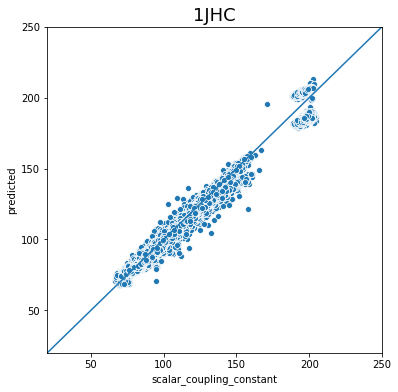

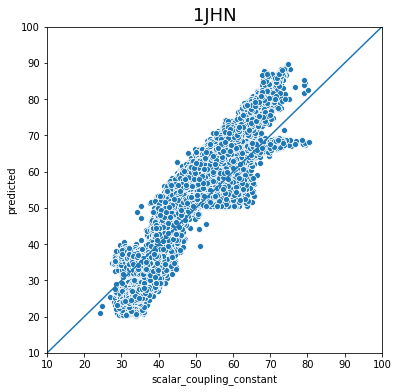

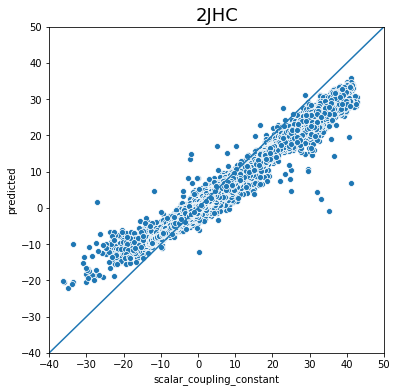

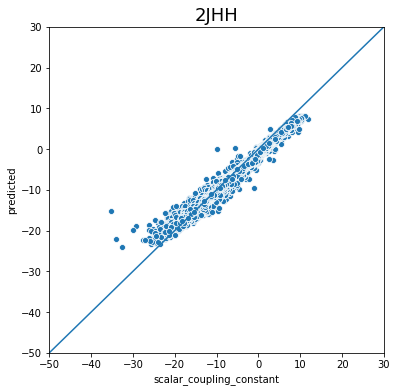

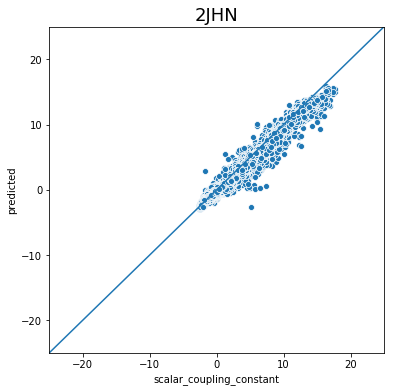

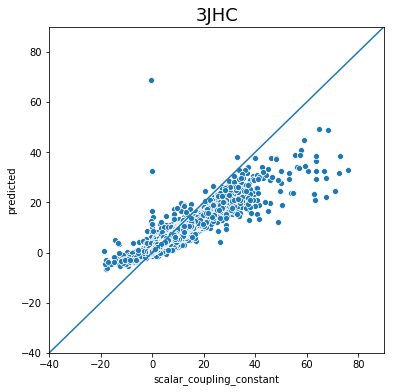

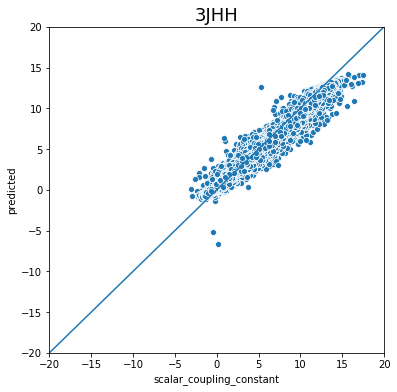

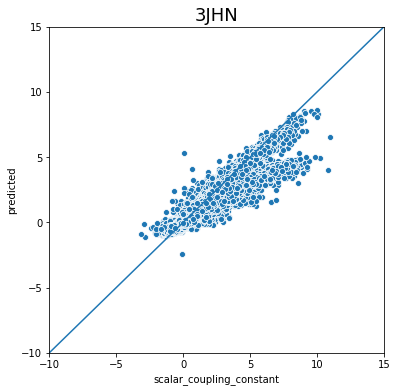

In [128]:
plot_data = pd.DataFrame(y, columns=['scalar_coupling_constant'])
plot_data.index.name = 'id'
plot_data['yhat'] = X_short['oof']
plot_data['type'] = type_train

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 20, 250)
plot_oof_preds('1JHN', 10, 100)
plot_oof_preds('2JHC', -40, 50)
plot_oof_preds('2JHH', -50, 30)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -40, 90)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -10, 15)